In [1]:
import pandas as pd
import numpy as np
import string
from __future__ import division
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import gensim
from gensim.models import Word2Vec
import logging

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in Data 

In [2]:
df = pd.read_table('data/quora_duplicate_questions.tsv')
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Drop Null Values

In [5]:
df.dropna(inplace = True)
df.drop(['id','qid1','qid2'], axis=1, inplace = True)

In [6]:
df.shape

(404288, 3)

In [7]:
df.is_duplicate.value_counts()

0    255025
1    149263
Name: is_duplicate, dtype: int64

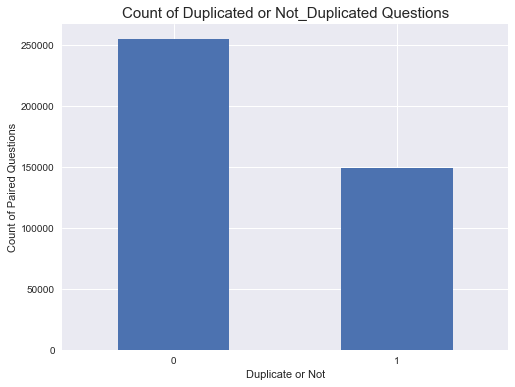

In [8]:
plt.rcParams['figure.figsize'] = (8, 6)
df.groupby('is_duplicate').is_duplicate.count().plot(kind='bar', rot=0)
plt.xlabel('Duplicate or Not')
plt.ylabel('Count of Paired Questions')
plt.title('Count of Duplicated or Not_Duplicated Questions', fontsize=15)
plt.show()

# Split Dataset into df_train and df_test

In [9]:
X = df[['question1', 'question2']]
y = df.is_duplicate

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [11]:
df_train = pd.concat([X_train, y_train], axis=1)

In [12]:
df_test = pd.concat([X_test, y_test], axis=1)

In [13]:
# Null Model for df_test
y_test.value_counts()[0]/len(y_test)

0.62979544386455266

# Method One:  Regular Feature Engineering

In [14]:
# Get stopwords_set and punctuation set.
stopwords_set = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [15]:
# Get unigrams for each sentence.
def get_unigram_sentence(sentence):
    return [word for word in word_tokenize(sentence.lower()) if word not in stopwords_set and\
            word not in punctuation]

## Get common_unigram_ratio Feature

In [16]:
# Function to get unigrams of question1 and question2.
def get_unigrams(df):
    df['question1_unigram'] = df['question1'].apply(lambda x:\
                                             get_unigram_sentence(x.decode(encoding='utf-8')))
    df['question2_unigram'] = df['question2'].apply(lambda x:\
                                             get_unigram_sentence(x.decode(encoding='utf-8')))

In [17]:
# Get unigrams of question1 and question2 of training dataset.
get_unigrams(df_train)

In [18]:
# Function to get common_unigram_ratio.
def get_common_unigram_ratio(df):
    df['common_unigram_count'] = df.apply(lambda x: len(set(x['question1_unigram']).\
                                        intersection(set(x['question2_unigram']))), axis=1)
    
    df['unigram_count'] = df.apply(lambda x: max(len(set(x['question1_unigram']).\
                                   union(set(x['question2_unigram']))), 1), axis=1)
    
    df['common_unigram_ratio'] = df['common_unigram_count'] / df['unigram_count']

In [19]:
# Get common_unigram_ratio of training dataset.
get_common_unigram_ratio(df_train)

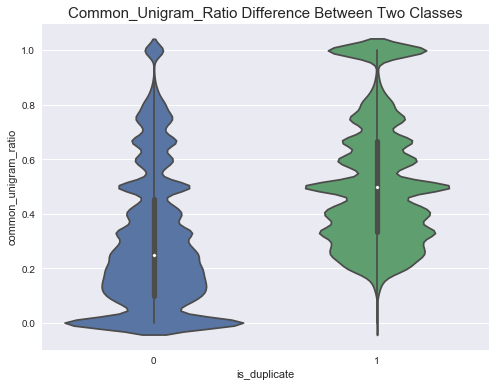

In [20]:
# Plot to show common_unigram_ratio difference between two classes.
plt.figure(figsize=(8,6))
sns.violinplot(x='is_duplicate', y='common_unigram_ratio', data=df_train)
plt.title('Common_Unigram_Ratio Difference Between Two Classes', fontsize=15)
plt.savefig('image/common_unigram_ratio_violinplot')

## Get common_bigram_ratio Feature

In [21]:
# Function to get bigrams of question1 and question2.
def get_bigrams(df):
    df['question1_bigram'] = df['question1_unigram'].apply(lambda x: [i for i in ngrams(x, 2)])
    df['question2_bigram'] = df['question2_unigram'].apply(lambda x: [i for i in ngrams(x, 2)])                                             

In [22]:
# Get bigrams of question1 and question2 of training dataset.
get_bigrams(df_train)

In [23]:
# Function to get common_bigram_ratio.
def get_common_bigram_ratio(df):
    df['common_bigram_count'] = df.apply(lambda x: len(set(x['question1_bigram']).\
                                         intersection(set(x['question2_bigram']))), axis=1)

    df['bigram_count'] = df.apply(lambda x: max(len(set(x['question1_bigram']).\
                                union(set(x['question2_bigram']))), 1), axis=1)

    df['common_bigram_ratio'] = df['common_bigram_count'] / df['bigram_count']   

In [24]:
# Get common_bigram_ratio of training dataset.
get_common_bigram_ratio(df_train)

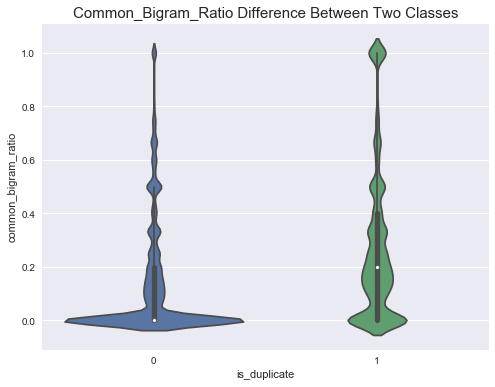

In [25]:
# Plot to show common_bigram_ratio difference between two classes.
plt.figure(figsize=(8,6))
sns.violinplot(x='is_duplicate', y='common_bigram_ratio', data=df_train)
plt.title('Common_Bigram_Ratio Difference Between Two Classes', fontsize=15)
plt.savefig('image/common_bigram_ratio_violinplot')

## Get common_trigram_ratio Feature

In [26]:
# Function to get trigrams of question1 and question2.
def get_trigrams(df):
    df['question1_trigram'] = df['question1_unigram'].apply(lambda x: [i for i in ngrams(x, 3)])
    df['question2_trigram'] = df['question2_unigram'].apply(lambda x: [i for i in ngrams(x, 3)])

In [27]:
# Get trigrams of question1 and question2 of traning dataset.
get_trigrams(df_train)

In [28]:
# Function to get common_trigram_ratio of question1 and question2.
def get_common_trigram_ratio(df):
    df['common_trigram_count'] = df.apply(lambda x: len(set(x['question1_trigram']).\
                                          intersection(set(x['question2_trigram']))), axis=1)

    df['trigram_count'] = df.apply(lambda x: max(len(set(x['question1_trigram']).\
                                   union(set(x['question2_trigram']))), 1), axis=1)

    df['common_trigram_ratio'] = df['common_trigram_count'] / df['trigram_count'] 

In [29]:
# Get common_trigram_ratio of question1 and question2 of training dataset.
get_common_trigram_ratio(df_train)

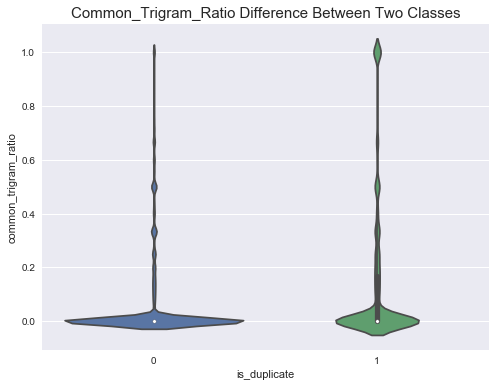

In [30]:
# Plot to show common_trigram_ratio difference between two classes.
plt.figure(figsize=(8,6))
sns.violinplot(x='is_duplicate', y='common_trigram_ratio', data=df_train)
plt.title('Common_Trigram_Ratio Difference Between Two Classes', fontsize=15)
plt.savefig('image/common_trigram_ratio_violinplot')

## Get cosine_similarity Feature

In [31]:
# Make tfidf_matrix of paired quesions.
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_set)
tfidf_matrix = tfidf_vectorizer.fit(df_train.question1.values + df_train.question1.values)

In [32]:
# Function to get cosine_similarity of each paired questions.
def get_cosine_similarity(df):
    tfidf_matrix_transform1 = tfidf_vectorizer.transform(df.question1.values)
    tfidf_matrix_transform2 = tfidf_vectorizer.transform(df.question2.values)
    cos = []
    for i in range(len(df)):
        cos.append(cosine_similarity(tfidf_matrix_transform1[i].toarray(),\
                                     tfidf_matrix_transform2[i].toarray()))

    df['cosine_similarity'] = cos
    df['cosine_similarity'] = df.cosine_similarity.apply(lambda x: x[0][0])

In [33]:
# Get cosine_similarity of each paired quesions of training dataset.
get_cosine_similarity(df_train)

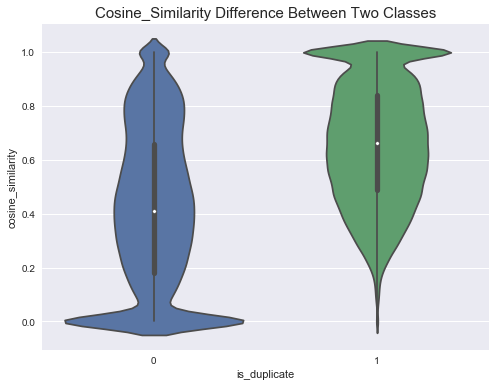

In [34]:
# Plot to show cosine_similarity difference between two classes.
plt.figure(figsize=(8,6))
sns.violinplot(x='is_duplicate', y='cosine_similarity', data=df_train)
plt.title('Cosine_Similarity Difference Between Two Classes', fontsize=15)
plt.savefig('image/cosine_similarity_violinplot')

# Models

In [35]:
feature_cols = ['common_unigram_ratio', 'common_bigram_ratio','common_trigram_ratio',\
                'cosine_similarity']
df_train_X = df_train[feature_cols]
df_train_y = df_train.is_duplicate

In [36]:
# Random Forest Clssifier Model
rfc_grid = {'max_depth': [3, 5],
            'n_estimators': [100, 300],
            'max_features': ['sqrt']}
rfc_gridsearch = GridSearchCV(RandomForestClassifier(),
                                 rfc_grid,
                                 n_jobs=-1,
                                 cv = 3,
                                 scoring='accuracy')
rfc_gridsearch.fit(df_train_X, df_train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300], 'max_features': ['sqrt'], 'max_depth': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [37]:
rfc_gridsearch.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}

In [38]:
rfc_gridsearch.best_score_

0.69664897666403747

In [40]:
# Gradient Boosting Classifier Model
gbc_grid = {'learning_rate': [0.01,0.1],
            'n_estimators': [100, 300],
            'max_features': ['sqrt']}
gbc_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gbc_grid,
                                 n_jobs=-1,
                                 verbose=True,)
gbc_gridsearch.fit(df_train_X, df_train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300], 'max_features': ['sqrt'], 'learning_rate': [0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [41]:
gbc_gridsearch.best_params_

{'learning_rate': 0.1, 'max_features': 'sqrt', 'n_estimators': 300}

In [42]:
gbc_gridsearch.best_score_

0.70650719097232717

## Test on Testing Dataset

In [43]:
get_unigrams(df_test)
get_common_unigram_ratio(df_test)
get_bigrams(df_test)
get_common_bigram_ratio(df_test)
get_trigrams(df_test)
get_common_trigram_ratio(df_test)
get_cosine_similarity(df_test)

In [44]:
df_test_X = df_test[feature_cols]
df_test_y = df_test.is_duplicate

In [45]:
gbc = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', n_estimators=300)

In [46]:
gbc.fit(df_train_X, df_train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [47]:
def get_scores(model, df_test_X, df_test_y):
    model_accuracy_score = accuracy_score(df_test_y, model.predict(df_test_X))
    model_recall_score = recall_score(df_test_y, model.predict(df_test_X))
    model_precision_score = precision_score(df_test_y, model.predict(df_test_X))
    model_roc_auc_score = roc_auc_score(df_test_y, model.predict_proba(df_test_X)[:,1])
    print 'Accuracy Score = {:.2f}\nRecall Score= {:.2f}\nPrecision Score = {:.2f}\nAUC_Score = {:.2f}'.\
      format(model_accuracy_score, model_recall_score, model_precision_score, model_roc_auc_score)

In [48]:
get_scores(gbc, df_test_X, df_test_y)

Accuracy Score = 0.71
Recall Score= 0.62
Precision Score = 0.60
AUC_Score = 0.79


# Method 2:    Word2Vec

In [49]:
# Configure the logging model so that Word2Vec creates nice output messages.
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)

## Word2vec Self_Trained  Model

In [50]:
# Get unigrams of the whole dataset.
get_unigrams(df)

In [51]:
# Combine question1 and question2 to list.
sentences = df.question1_unigram.tolist() + df.question2_unigram.values.tolist()

In [52]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [53]:
# Initialize and train the model.
model_self_trained = Word2Vec(sentences, workers=num_workers, \
                 size=num_features, min_count=min_word_count, \
                 window=context, sample=downsampling)

INFO : collecting all words and their counts
INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO : PROGRESS: at sentence #10000, processed 56055 words, keeping 12305 word types
INFO : PROGRESS: at sentence #20000, processed 112347 words, keeping 18019 word types
INFO : PROGRESS: at sentence #30000, processed 168329 words, keeping 22381 word types
INFO : PROGRESS: at sentence #40000, processed 223916 words, keeping 26035 word types
INFO : PROGRESS: at sentence #50000, processed 280112 words, keeping 29414 word types
INFO : PROGRESS: at sentence #60000, processed 336149 words, keeping 32418 word types
INFO : PROGRESS: at sentence #70000, processed 392143 words, keeping 35084 word types
INFO : PROGRESS: at sentence #80000, processed 448240 words, keeping 37420 word types
INFO : PROGRESS: at sentence #90000, processed 504265 words, keeping 39694 word types
INFO : PROGRESS: at sentence #100000, processed 560283 words, keeping 41892 word types
INFO : PROGRESS: at se

In [54]:
# Make the model much more memory-efficient.
model_self_trained.init_sims(replace=True)

INFO : precomputing L2-norms of word weight vectors


In [55]:
# Save the model.
model_self_trained.save('model/paired_qeustion_300f_40m_10c')

INFO : saving Word2Vec object under model/paired_qeustion_300f_40m_10c, separately None
INFO : not storing attribute syn0norm
INFO : storing np array 'syn0' to model/paired_qeustion_300f_40m_10c.wv.syn0.npy
INFO : storing np array 'syn1neg' to model/paired_qeustion_300f_40m_10c.syn1neg.npy
INFO : not storing attribute cum_table
INFO : saved model/paired_qeustion_300f_40m_10c


In [56]:
# Load the model.
model_self_trained = Word2Vec.load("model/paired_qeustion_300f_40m_10c")

INFO : loading Word2Vec object from model/paired_qeustion_300f_40m_10c
INFO : loading wv recursively from model/paired_qeustion_300f_40m_10c.wv.* with mmap=None
INFO : loading syn0 from model/paired_qeustion_300f_40m_10c.wv.syn0.npy with mmap=None
INFO : setting ignored attribute syn0norm to None
INFO : loading syn1neg from model/paired_qeustion_300f_40m_10c.syn1neg.npy with mmap=None
INFO : setting ignored attribute cum_table to None
INFO : loaded model/paired_qeustion_300f_40m_10c


In [57]:
# Get the names of the words in the model's vocabulary. Convert it to a set, for speed.
model_words = set()
for item in sentences:
    for i in item:
        model_words.add(i)

In [58]:
# Function to average all of the word vectors.
def make_feature_vec(df, model, model_words, num_features):
    counter = 0
    # Pre-initialize an empty numpy array (for speed)
    df_vecs = np.zeros((len(df), num_features), dtype= 'float32')
    for i in df.index.values:
        words = df.question1_unigram[i] + df.question2_unigram[i]
        set_words = set(words)
        nwords = 0.
        feature_vecs = np.zeros((num_features,), dtype= 'float32')
    #  Loop over each word in the question1 and question2 and, if it is in the model's vocaublary,\
    #  add its feature vector to the total.
        for word in set_words:
            if word in model_words: 
                nwords = nwords + 1
                feature_vecs = np.add(feature_vecs,model[word])
        df_vecs[counter] = np.divide(feature_vecs, nwords + 1.)                                 
        counter += 1
    return df_vecs 

In [60]:
# Get training dataset vectors.
df_train_vecs_s = make_feature_vec(df_train, model_self_trained, model_words, num_features)

In [61]:
# Get testing dataset vectors.
df_test_vecs_s = make_feature_vec(df_test, model_self_trained, model_words, num_features)

In [62]:
# Fit the model
rmc = RandomForestClassifier(n_estimators=10)

In [63]:
rmc.fit(df_train_vecs_s, df_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [64]:
get_scores(rmc, df_test_vecs_s, df_test_y)

Accuracy Score = 0.77
Recall Score= 0.55
Precision Score = 0.76
AUC_Score = 0.83


## Word2Vec Google News Pre-Trained Model

In [65]:
# Get Google News pre_trainded model.
model_google_news = gensim.models.KeyedVectors.load_word2vec_format('/Users/lihuama/Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

INFO : loading projection weights from /Users/lihuama/Downloads/GoogleNews-vectors-negative300.bin
INFO : loaded (3000000, 300) matrix from /Users/lihuama/Downloads/GoogleNews-vectors-negative300.bin


In [66]:
# Get names of the words in the Google News model's vocabulary. 
index2word_set = set(model_google_news.index2word)

In [67]:
# Get training dataset vectors
df_train_vecs_g = make_feature_vec(df_train, model_google_news, index2word_set, num_features)

In [68]:
# Get testing dataset vectors
df_train_vecs_g = make_feature_vec(df_train, model_google_news,index2word_set, num_features)

In [69]:
rmc_modelg = RandomForestClassifier(n_estimators=10)
rmc_modelg.fit(df_train_vecs_g, df_train_y)
get_scores(rmc_modelg, df_test_vecs_g, df_test_y)

Accuracy Score = 0.61
Recall Score= 0.07
Precision Score = 0.35
AUC_Score = 0.49
